In [6]:
!pip install -q pandas numpy statsmodels scipy matplotlib

In [8]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# ---- File paths (edit if your files are elsewhere) ----
EVENT_FILE = "event_window_export_correct_dummy.csv"
EARN_FILE  = "earnings_with_macro.csv"
OUTDIR     = Path("outputs")
OUTDIR.mkdir(exist_ok=True)

# ---- Helper: find a date column automatically ----
def find_date_col(df):
    for c in df.columns:
        cl = c.lower()
        if "date" in cl or "announce" in cl or "event" in cl:
            return c
    # if not found, try to coerce any column to datetime and pick first success
    for c in df.columns:
        try:
            _ = pd.to_datetime(df[c], errors="raise")
            return c
        except Exception:
            pass
    raise ValueError("No date-like column found. Please rename your date column to include 'date' or 'announce'.")

# ---- Helper: list return window cols like Ret_+1D, Ret_-7D, etc. ----
RET_PATTERN = re.compile(r"^Ret_[\+\-]\d+D$")
def find_return_cols(df):
    return [c for c in df.columns if RET_PATTERN.match(c)]

# ---- Helper: safe zscore (for optional outlier check) ----
def zscore_s(x):
    x = pd.Series(x).astype(float)
    return (x - x.mean()) / x.std(ddof=0)

In [10]:
# Load event-window file
ev = pd.read_csv(EVENT_FILE)
ev_date_col = find_date_col(ev)
ev[ev_date_col] = pd.to_datetime(ev[ev_date_col], errors="coerce")
ev = ev.dropna(subset=[ev_date_col]).sort_values(ev_date_col).reset_index(drop=True)

# Detect relative-day column if present (e.g., rel_day, t, day_offset)
rel_day_col = None
for cand in ["rel_day","relative_day","t","day_offset","k","tau"]:
    if cand in ev.columns:
        rel_day_col = cand
        break

# Load earnings+macro file
em = pd.read_csv(EARN_FILE)
em_date_col = find_date_col(em)
em[em_date_col] = pd.to_datetime(em[em_date_col], errors="coerce")
em = em.dropna(subset=[em_date_col]).sort_values(em_date_col).reset_index(drop=True)

# Standardize column names we’ll use later
ev = ev.rename(columns={ev_date_col:"EventDate"})
em = em.rename(columns={em_date_col:"EventDate"})

print("EVENT rows:", len(ev), "columns:", list(ev.columns)[:10], "...")
print("EARN+MACRO rows:", len(em), "columns:", list(em.columns)[:10], "...")

# Try to find EPS columns and create EPS_Surprise if missing
eps_est = next((c for c in em.columns if "estimate" in c.lower() and "eps" in c.lower()), None)
eps_act = next((c for c in em.columns if ("actual" in c.lower() or "reported" in c.lower()) and "eps" in c.lower()), None)
if "EPS_Surprise" not in em.columns and eps_est and eps_act:
    em["EPS_Surprise"] = pd.to_numeric(em[eps_act], errors="coerce") - pd.to_numeric(em[eps_est], errors="coerce")

# Find return window columns in either file
ev_ret_cols = find_return_cols(ev)
em_ret_cols = find_return_cols(em)
print("Return cols in EVENT file:", ev_ret_cols)
print("Return cols in EARN+MACRO file:", em_ret_cols)

EVENT rows: 2709 columns: ['Ticker', 'EventDate', 't', 'ret', 'dist', 'eps_estimate', 'eps_actual', 'eps_surprise', 'surprise_pct', 'yf_eps_estimate'] ...
EARN+MACRO rows: 129 columns: ['Ticker', 'EventDate', 'Year', 'Month', 'eps_estimate', 'eps_actual', 'eps_surprise', 'surprise_pct', 'yf_eps_estimate', 'yf_eps_actual'] ...
Return cols in EVENT file: []
Return cols in EARN+MACRO file: []


/var/folders/xh/771g8qzd27x_4gxszttpc5yc0000gn/T/ipykernel_53909/2075170196.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ev[ev_date_col] = pd.to_datetime(ev[ev_date_col], errors="coerce")


In [12]:
# Strategy:
# - If return windows exist in em, use those.
# - Else if they exist in ev, bring them over by merging on EventDate.
# - Keep macro & EPS info from em.

master = em.copy()

if not em_ret_cols and ev_ret_cols:
    # Merge return windows from ev (deduplicate per EventDate first if needed)
    ret_cols = ["EventDate"] + ev_ret_cols
    ev_ret = ev[ret_cols].drop_duplicates(subset=["EventDate"], keep="last")
    master = master.merge(ev_ret, on="EventDate", how="left")

# If both have return columns, prefer the em ones and fill missing from ev
elif em_ret_cols and ev_ret_cols:
    ret_cols = ["EventDate"] + ev_ret_cols
    ev_ret = ev[ret_cols].drop_duplicates(subset=["EventDate"], keep="last")
    m2 = master.merge(ev_ret, on="EventDate", how="left", suffixes=("","_ev"))
    for c in em_ret_cols:
        alt = c + "_ev"
        if alt in m2.columns:
            m2[c] = m2[c].fillna(m2[alt])
            m2 = m2.drop(columns=[alt])
    master = m2

# Sanity
print("Master shape:", master.shape)
master.head()

Master shape: (129, 21)


,Ticker,EventDate,Year,Month,eps_estimate,eps_actual,eps_surprise,surprise_pct,yf_eps_estimate,yf_eps_actual,...,yf_Event Type,Real GDP (QoQ),CPI (Inflation Index),Fed Funds Rate,10Y Treasury Rate,Unemployment Rate,Non-Farm Payrolls,Consumer Sentiment,Yield Curve (10Y - 2Y),EPS_Surprise
0,AAPL,2015-01-27,2015,1,0.65,0.77,0.12,17.52,0.65,0.77,...,Earnings,NaN,236.252,0.12,2.21,5.6,140364.0,93.6,1.571818,0.12
1,GOOGL,2015-01-29,2015,1,0.36,0.34,-0.02,-3.28,0.36,0.34,...,Earnings,NaN,236.252,0.12,2.21,5.6,140364.0,93.6,1.571818,-0.02
2,NVDA,2015-02-11,2015,2,0.07,0.09,0.02,22.62,0.07,0.09,...,Earnings,18666.621,234.747,0.11,1.88,5.7,140568.0,98.1,1.330000,0.02
3,GOOGL,2015-04-23,2015,4,0.33,0.33,0.00,-0.40,0.33,0.33,...,Earnings,NaN,235.976,0.11,2.04,5.4,140923.0,93.0,1.402273,0.00
4,AAPL,2015-04-27,2015,4,0.54,0.58,0.04,7.93,0.54,0.58,...,Earnings,NaN,235.976,0.11,2.04,5.4,140923.0,93.0,1.402273,0.04


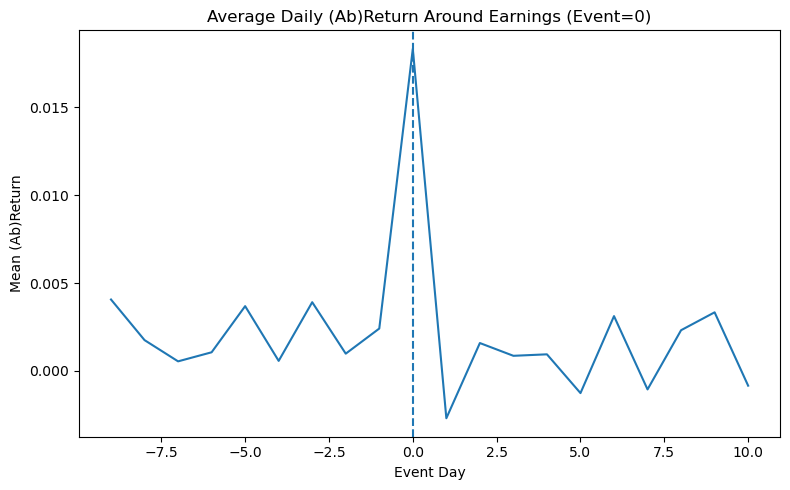

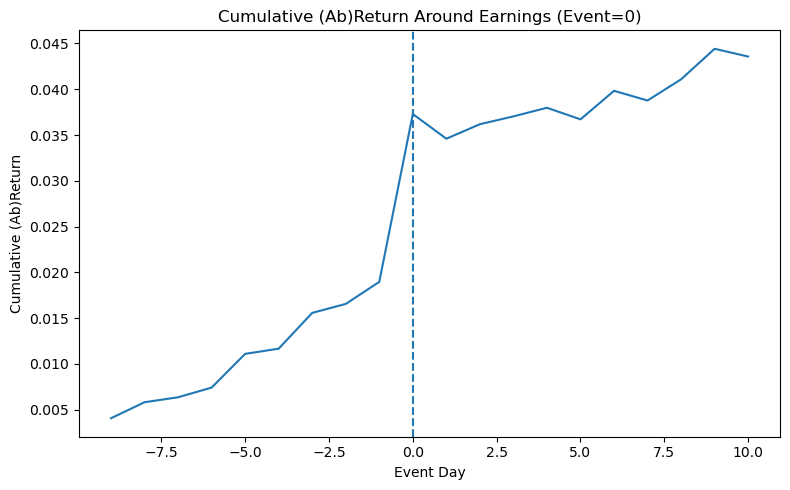

In [14]:
if rel_day_col is not None:
    # Try to find a per-day return or abnormal return column
    per_day_return_col = None
    # common possibilities in event-window exports
    for cand in ["ret","return","abret","abnormal_return","AR","dr","daily_ret"]:
        if any(cand.lower() == c.lower() for c in ev.columns):
            per_day_return_col = next(c for c in ev.columns if cand.lower()==c.lower())
            break

    if per_day_return_col:
        # Average across events
        avg_by_day = ev.groupby(rel_day_col)[per_day_return_col].mean().sort_index()
        car_by_day = avg_by_day.cumsum()

        plt.figure(figsize=(8,5))
        plt.plot(avg_by_day.index, avg_by_day.values)
        plt.axvline(0, linestyle="--")
        plt.title("Average Daily (Ab)Return Around Earnings (Event=0)")
        plt.xlabel("Event Day")
        plt.ylabel("Mean (Ab)Return")
        plt.tight_layout()
        plt.savefig(OUTDIR/"avg_ar_by_day.png", dpi=150)
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(car_by_day.index, car_by_day.values)
        plt.axvline(0, linestyle="--")
        plt.title("Cumulative (Ab)Return Around Earnings (Event=0)")
        plt.xlabel("Event Day")
        plt.ylabel("Cumulative (Ab)Return")
        plt.tight_layout()
        plt.savefig(OUTDIR/"car_by_day.png", dpi=150)
        plt.show()
    else:
        print("No per-day return/abnormal-return column found in event-window file. Skipping event-day plot.")
else:
    print("No relative-day column found in event-window file. Skipping event-day plot.")

In [16]:
# Identify EPS_Surprise; if missing, skip this section gracefully
if "EPS_Surprise" in master.columns:
    master["Beat"] = master["EPS_Surprise"] > 0

    # Pick a default horizon (change if you prefer)
    candidate_y = ["Ret_+1D","Ret_+3D","Ret_+7D","Ret_+30D"]
    ycol = next((c for c in candidate_y if c in master.columns), None)

    if ycol:
        # Averages
        avg = master.groupby("Beat")[ycol].mean().rename({False:"Miss", True:"Beat"})
        print(f"Average {ycol} — Miss vs Beat:\n", avg)

        # t-test
        miss = master.loc[master["Beat"]==False, ycol].dropna()
        beat = master.loc[master["Beat"]==True,  ycol].dropna()
        if len(miss)>1 and len(beat)>1:
            t, p = stats.ttest_ind(beat, miss, equal_var=False, nan_policy="omit")
            print(f"T-test ({ycol}) Beat vs Miss: t={t:.2f}, p={p:.4f}")
        else:
            print("Not enough observations for a t-test at this horizon.")

        # Simple boxplot
        plt.figure(figsize=(6,5))
        data = [miss.values, beat.values]
        plt.boxplot(data, labels=["Miss","Beat"])
        plt.title(f"{ycol}: Beat vs Miss")
        plt.ylabel("Return")
        plt.tight_layout()
        plt.savefig(OUTDIR/f"box_{ycol}_beat_vs_miss.png", dpi=150)
        plt.show()
    else:
        print("No return window columns like Ret_+1D/3D/7D/30D found.")
else:
    print("EPS_Surprise not found in earnings file — skipping Beats vs Misses.")

No return window columns like Ret_+1D/3D/7D/30D found.


                        Year  Month  eps_estimate  eps_actual  eps_surprise  \
Year                    1.00  -0.07          0.69        0.70          0.23   
Month                  -0.07   1.00         -0.10       -0.11         -0.04   
eps_estimate            0.69  -0.10          1.00        0.98          0.39   
eps_actual              0.70  -0.11          0.98        1.00          0.56   
eps_surprise            0.23  -0.04          0.39        0.56          1.00   
surprise_pct           -0.14   0.07         -0.16       -0.01          0.65   
yf_eps_estimate         0.69  -0.10          1.00        0.98          0.39   
yf_eps_actual           0.70  -0.11          0.98        1.00          0.56   
yf_surprise_pct        -0.14   0.07         -0.16       -0.01          0.65   
Real GDP (QoQ)          0.97   0.03          0.68        0.64          0.15   
CPI (Inflation Index)   0.96   0.00          0.71        0.70          0.16   
Fed Funds Rate          0.72   0.02          0.54   

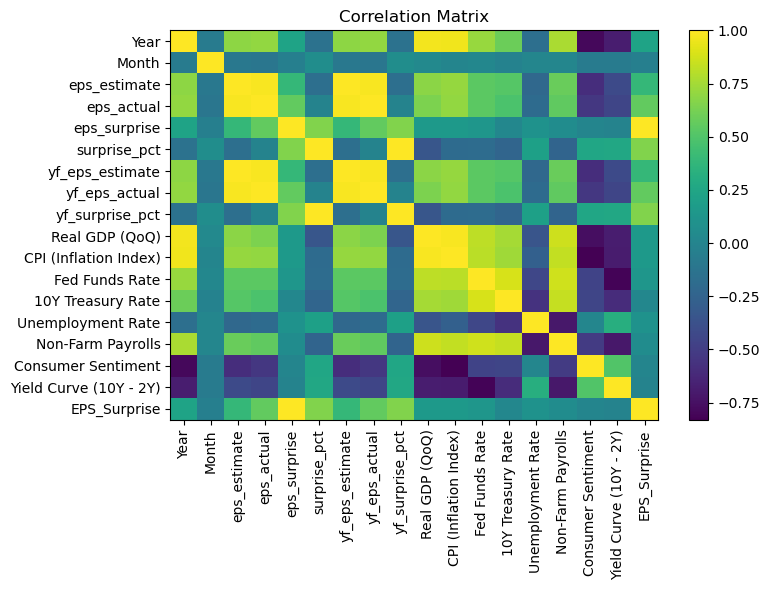

In [18]:
# Choose a reasonable subset of numeric columns for a correlation matrix
num = master.select_dtypes(include=[np.number]).copy()

# If columns like CPI_YoY, FedFunds, GDP_YoY exist, they’ll be included automatically
corr = num.corr().round(2)
print(corr)

# Heatmap (plain matplotlib)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.savefig(OUTDIR/"corr_matrix.png", dpi=150)
plt.show()

corr.to_csv(OUTDIR/"corr_matrix.csv")

In [20]:
# Pick a target horizon available in your data
target = next((c for c in ["Ret_+7D","Ret_+1D","Ret_+3D","Ret_+30D"] if c in master.columns), None)
if target is None:
    print("No return columns found for regression step.")
else:
    # Candidate features: EPS_Surprise + common macro names if present
    candidate_X = ["EPS_Surprise","CPI_YoY","FedFunds","GDP_YoY"]
    X_cols = [c for c in candidate_X if c in master.columns]

    if not X_cols:
        print("No candidate predictors (EPS_Surprise or macro) found — skipping OLS.")
    else:
        dfm = master[X_cols + [target]].dropna().copy()
        if dfm.empty:
            print("No rows with complete data for OLS. Skipping.")
        else:
            X = sm.add_constant(dfm[X_cols])
            y = dfm[target]
            model = sm.OLS(y, X).fit(cov_type="HC1")  # robust SE
            print(model.summary())

            # Save a text summary
            with open(OUTDIR/"ols_summary.txt","w") as f:
                f.write(model.summary().as_text())

No return columns found for regression step.


In [22]:
summary_items = {}

# Average pre/post returns if present
for col in ["Ret_-7D","Ret_+1D","Ret_+3D","Ret_+7D","Ret_+30D"]:
    if col in master.columns:
        summary_items[f"avg_{col}"] = np.nanmean(master[col])

# Beat vs miss at your chosen horizon
if "EPS_Surprise" in master.columns:
    for col in ["Ret_+1D","Ret_+7D","Ret_+30D"]:
        if col in master.columns:
            beat_mean = np.nanmean(master.loc[master["EPS_Surprise"]>0, col])
            miss_mean = np.nanmean(master.loc[master["EPS_Surprise"]<=0, col])
            summary_items[f"avg_{col}_Beat"] = beat_mean
            summary_items[f"avg_{col}_Miss"] = miss_mean

exec_df = pd.DataFrame([summary_items]).T.reset_index()
exec_df.columns = ["Metric","Value"]
exec_df.to_csv(OUTDIR/"executive_summary.csv", index=False)
exec_df

,Metric,Value


In [24]:
import re

def normalize_ret_cols(df):
    ren = {}
    for c in df.columns:
        cl = c.lower().replace(" ", "")
        m = re.match(r"ret[_\s]*([+\-]?\d+)d$", cl) or re.match(r"ret([+\-]?\d+)d$", cl) \
            or re.match(r"ret[_\s]*([+\-]?\d+)$", cl)  # allows 'ret_+7'
        if m:
            k = m.group(1)
            if not k.startswith('+') and not k.startswith('-'):
                k = '+' + k
            new = f"Ret_{k}D"
            ren[c] = new
    return df.rename(columns=ren)

# apply to both sources early, just after loading:
ev = normalize_ret_cols(ev)
em = normalize_ret_cols(em)

In [26]:
ycol = "Ret_+7D" if "Ret_+7D" in master.columns else None

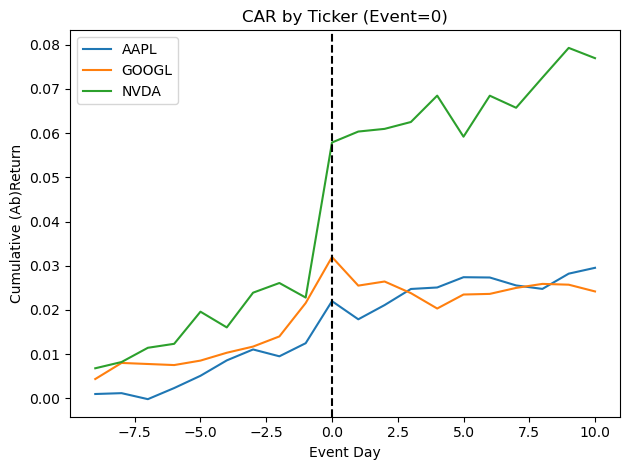

In [28]:
if rel_day_col is not None:
    # try to identify a per-day return/abreturn column
    cand_cols = [c for c in ev.columns if c.lower() in {"ret","abret","abnormal_return","ar","daily_ret"}]
    if cand_cols:
        rcol = cand_cols[0]
        for tk, sub in ev.groupby("Ticker"):
            avg = sub.groupby(rel_day_col)[rcol].mean().sort_index().cumsum()
            plt.plot(avg.index, avg.values, label=tk)
        plt.axvline(0, ls="--", color="k")
        plt.title("CAR by Ticker (Event=0)")
        plt.xlabel("Event Day"); plt.ylabel("Cumulative (Ab)Return")
        plt.legend(); plt.tight_layout()
        plt.savefig(OUTDIR/"car_by_ticker.png", dpi=150); plt.show()

In [30]:
def winsorize(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

target = "Ret_+7D" if "Ret_+7D" in master.columns else None
if target:
    predictors = [c for c in ["EPS_Surprise","CPI_YoY","FedFunds","GDP_YoY"] if c in master.columns]
    extra_dums = []
    if "Ticker" in master.columns: extra_dums.append(pd.get_dummies(master["Ticker"], prefix="TK", drop_first=True))
    if "Year" in master.columns:   extra_dums.append(pd.get_dummies(master["Year"],   prefix="Y",  drop_first=True))

    if predictors:
        X = master[predictors].copy()
        if extra_dums: X = pd.concat([X] + extra_dums, axis=1)

        dfm = pd.concat([winsorize(master[target]), X], axis=1).dropna()
        y = dfm[target]; X = sm.add_constant(dfm.drop(columns=[target]))
        model = sm.OLS(y, X).fit(cov_type="HC1")
        print(model.summary())
        with open(OUTDIR/"ols_fe_winsor.txt","w") as f: f.write(model.summary().as_text())

In [32]:
master.to_csv(OUTDIR/"master_final.csv", index=False)

import shutil
shutil.make_archive("deliverables", "zip", root_dir=OUTDIR)
print("Saved deliverables.zip")

Saved deliverables.zip
